# Tools & Libraries



In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import datetime
import random

import json
import os

from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind

pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [ ]:
!pip install -q kaggle

##### Setup credential

In [ ]:
# We can download data directly from kaggle.com with this setup

kaggle_username = "{fill_this_with_your_own_username}" # use your own username kaggle
kaggle_key = "{fill_this_with_your_own_token}" # user your own api token (this value comes from account -> setting -> generate api token from kaggle.com

kaggle_config = {
    "username": kaggle_username,
    "key": kaggle_key
}

os.makedirs("/root/.kaggle", exist_ok=True)

with open("/root/.kaggle/kaggle.json", "w") as f:
    json.dump(kaggle_config, f)

os.chmod("/root/.kaggle/kaggle.json", 600)

##### Download datasets from kaggle

In [ ]:
!kaggle datasets download -d sanxhi/ab-testing-data-simulated-web-user-engagement
!unzip ab-testing-data-simulated-web-user-engagement.zip

Dataset URL: https://www.kaggle.com/datasets/sanxhi/ab-testing-data-simulated-web-user-engagement
License(s): CC0-1.0
  0% 0.00/3.07M [00:00<?, ?B/s]
100% 3.07M/3.07M [00:00<00:00, 813MB/s]
Archive:  ab-testing-data-simulated-web-user-engagement.zip
  inflating: ab_test_dataset.csv     


# A/B Testing Data Analysis

## Data Checking

In [ ]:
df = pd.read_csv("ab_test_dataset.csv")
print(df.shape)
df.head()

(200020, 6)


,click,group,session_time,click_time,device_type,referral_source
0,1,exp,0.04036,NaN,mobile,search
1,0,exp,1.63957,2024-01-14 22:15:00,mobile,email
2,0,exp,2.96171,2024-01-01 15:36:00,mobile,direct
3,1,exp,2.78454,2024-01-04 17:39:00,desktop,email
4,0,exp,2.49587,2024-01-07 17:31:00,mobile,social


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200020 entries, 0 to 200019
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   click            200020 non-null  int64  
 1   group            198050 non-null  object 
 2   session_time     200020 non-null  float64
 3   click_time       198019 non-null  object 
 4   device_type      200020 non-null  object 
 5   referral_source  199031 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.2+ MB


In [ ]:
df.groupby('group')[['click']].count(), df.groupby('device_type')[['click']].count(), df.groupby('referral_source')[['click']].count()

(       click
 group       
 A        992
 Exp      995
 a        978
 con    97020
 con     1000
 exp    97065,
               click
 device_type        
 Desktop        1000
 MOBILE          998
 desktop       59419
 mobile       138603,
                  click
 referral_source       
  Social            993
 ads              19713
 direct           29690
 email            49636
 seach             1000
 search           58946
 social           39053)

In [ ]:
df.describe()

,click,session_time
count,200020.00000,200020.00000
mean,0.34886,13.01950
std,0.47661,80.02608
min,0.00000,0.00001
25%,0.00000,1.46056
50%,0.00000,3.52111
75%,1.00000,7.09105
max,1.00000,807.78581


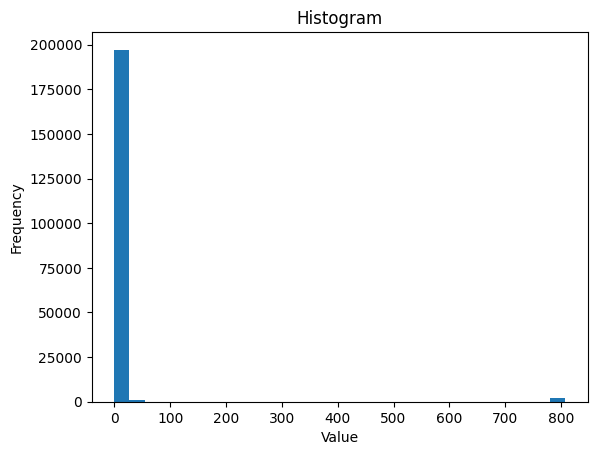

In [ ]:
plt.hist(df['session_time'], bins=30)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram")
plt.show()

## Data Cleaning & Preprocessing

In [ ]:
df['group'] = df['group'].str.lower().str.strip() # Standardize
df['device_type'] = df['device_type'].str.lower().str.strip() # Standardize
df['referral_source'] = df['referral_source'].str.lower().str.strip() # Standardize

df['referral_source'] = np.where(df['referral_source'] == 'seach', 'search', df['referral_source']) # Fixing Typo "seach"

df.groupby('group')[['click']].count(), df.groupby('device_type')[['click']].count(), df.groupby('referral_source')[['click']].count()

(       click
 group       
 a       1970
 con    98020
 exp    98060,
               click
 device_type        
 desktop       60419
 mobile       139601,
                  click
 referral_source       
 ads              19713
 direct           29690
 email            49636
 search           59946
 social           40046)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200020 entries, 0 to 200019
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   click            200020 non-null  int64  
 1   group            198050 non-null  object 
 2   session_time     200020 non-null  float64
 3   click_time       198019 non-null  object 
 4   device_type      200020 non-null  object 
 5   referral_source  199031 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.2+ MB


In [ ]:
# Drop value "a" in group (it's supposed to be typo)

df = df.dropna()
df = df[df['group'] != 'a']

In [ ]:
# Create session_time_group for interval per 5 seconds to check the distribution of the data easier
bins = np.arange(0, df['session_time'].max() + 5, 5)

df['session_time_group'] = pd.cut(
    df['session_time'],
    bins=bins,
    right=False  # left interval close: [0–5)
)

df.head()

,click,group,session_time,click_time,device_type,referral_source,session_time_group
1,0,exp,1.63957,2024-01-14 22:15:00,mobile,email,"[0.0, 5.0)"
2,0,exp,2.96171,2024-01-01 15:36:00,mobile,direct,"[0.0, 5.0)"
3,1,exp,2.78454,2024-01-04 17:39:00,desktop,email,"[0.0, 5.0)"
4,0,exp,2.49587,2024-01-07 17:31:00,mobile,social,"[0.0, 5.0)"
5,0,exp,10.40581,2024-01-05 11:02:00,desktop,social,"[10.0, 15.0)"


In [ ]:
df.groupby('session_time_group')[['click']].count().reset_index()

/tmp/ipython-input-3813675849.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('session_time_group')[['click']].count().reset_index()


,session_time_group,click
0,"[0.0, 5.0)",120840
1,"[5.0, 10.0)",44449
2,"[10.0, 15.0)",16591
3,"[15.0, 20.0)",5974
4,"[20.0, 25.0)",2104
5,"[25.0, 30.0)",810
6,"[30.0, 35.0)",301
7,"[35.0, 40.0)",101
8,"[40.0, 45.0)",35
9,"[45.0, 50.0)",14


There's outlier in interval 805s - 810s. We can exlude that for make it more
human behavior

In [ ]:
df[df['session_time_group'] == pd.Interval(805.0, 810.0, closed='left')].head()

,click,group,session_time,click_time,device_type,referral_source,session_time_group
101,0,exp,807.78581,2024-01-04 12:44:00,mobile,social,"[805.0, 810.0)"
560,0,exp,807.78581,2024-01-11 16:46:00,desktop,email,"[805.0, 810.0)"
571,1,exp,807.78581,2024-01-04 14:57:00,mobile,search,"[805.0, 810.0)"
603,0,exp,807.78581,2024-01-02 10:03:00,desktop,search,"[805.0, 810.0)"
607,1,exp,807.78581,2024-01-03 18:37:00,mobile,email,"[805.0, 810.0)"


In [ ]:
df = df[df['session_time_group'] != pd.Interval(805.0, 810.0, closed='left')]
print(df.shape)
df.head()

(191226, 7)


,click,group,session_time,click_time,device_type,referral_source,session_time_group
1,0,exp,1.63957,2024-01-14 22:15:00,mobile,email,"[0.0, 5.0)"
2,0,exp,2.96171,2024-01-01 15:36:00,mobile,direct,"[0.0, 5.0)"
3,1,exp,2.78454,2024-01-04 17:39:00,desktop,email,"[0.0, 5.0)"
4,0,exp,2.49587,2024-01-07 17:31:00,mobile,social,"[0.0, 5.0)"
5,0,exp,10.40581,2024-01-05 11:02:00,desktop,social,"[10.0, 15.0)"


## Check Data Distribution

In [ ]:
df['group'].value_counts()

,count
group,
exp,95725
con,95501


It's balance, so it's good

In [ ]:
pd.crosstab(df['group'], df['device_type'], normalize='index')

device_type,desktop,mobile
group,,
con,0.30164,0.69836
exp,0.30294,0.69706


Device type data has a good distribution (balance)

In [ ]:
pd.crosstab(df['group'], df['referral_source'], normalize='index')

referral_source,ads,direct,email,search,social
group,,,,,
con,0.10005,0.14996,0.24767,0.30229,0.20003
exp,0.09866,0.14812,0.25066,0.30040,0.20216


Refferal source data has a good distribution as well

In [ ]:
df.groupby(['referral_source', 'group'])['click'].mean().reset_index()

,referral_source,group,click
0,ads,con,0.20314
1,ads,exp,0.49619
2,direct,con,0.20362
3,direct,exp,0.49503
4,email,con,0.19756
5,email,exp,0.49621
6,search,con,0.20160
7,search,exp,0.49551
8,social,con,0.20306
9,social,exp,0.49948


We can see cleary there's positive significant impact in experiment (CTR higher)

In [ ]:
df.groupby(['device_type', 'group'])['click'].mean().reset_index()

,device_type,group,click
0,desktop,con,0.20342
1,desktop,exp,0.49964
2,mobile,con,0.20045
3,mobile,exp,0.49511


We can see cleary there's positive significant impact in experiment (CTR higher)

In [ ]:
df.groupby(['referral_source', 'group'])['session_time'].mean().reset_index()

,referral_source,group,session_time
0,ads,con,5.01696
1,ads,exp,5.02279
2,direct,con,4.96614
3,direct,exp,5.00840
4,email,con,5.01158
5,email,exp,4.96317
6,search,con,4.98567
7,search,exp,4.99401
8,social,con,4.99012
9,social,exp,5.01480


In [ ]:
df.groupby(['device_type', 'group'])['session_time'].mean().reset_index()

,device_type,group,session_time
0,desktop,con,5.01145
1,desktop,exp,5.00487
2,mobile,con,4.98529
3,mobile,exp,4.99136


## Significance Test

### Z-Test : CTR

In [ ]:
# If value P < 0.05, it's indicating that experiment affects CTR significanlty

from statsmodels.stats.proportion import proportions_ztest

con_ctr = df[df['group']=='con']['click']
exp_ctr = df[df['group']=='exp']['click']

count = [exp_ctr.sum(), con_ctr.sum()]
nobs = [len(exp_ctr), len(con_ctr)]

stat, pval = proportions_ztest(count, nobs)

stat = float(stat)
pval = float(pval)

print(f"Z-statistic: {stat:.2f}")
print(f"P-value: {pval:.4f}")


Z-statistic: 135.37
P-value: 0.0000


### T-Test Average Session Time

In [ ]:
# If value P < 0.05, it's indicating that experiment affects average session time significanlty

from scipy.stats import ttest_ind

con_avg_session = df[df['group']=='con']['session_time']
exp_avg_session = df[df['group']=='exp']['session_time']

stat, pval = ttest_ind(exp_avg_session, con_avg_session, equal_var=False)  # Welch t-test (lebih aman)

print("t-stat:", round(stat, 4))
print("p-value:", round(pval, 6))

t-stat: 0.1
p-value: 0.920321


## Uplift Results

### CTR

In [ ]:
# How big the impact

control_rate_ctr = con_ctr.mean()
exp_rate_ctr = exp_ctr.mean()

uplift = (exp_rate_ctr - control_rate_ctr) / control_rate_ctr

uplift = float(uplift)
print(f"Uplift: {(100*uplift):.2f}%")

Uplift: 146.58%


### Average Session Time

In [ ]:
# How big the impact

control_rate_avg_session = con_avg_session.mean()
exp_rate_avg_session = exp_avg_session.mean()

uplift = (exp_rate_avg_session - control_rate_avg_session) / control_rate_avg_session

uplift = float(uplift)
print(f"Uplift: {(100*uplift):.2f}%")

Uplift: 0.05%


In [ ]:
print("Control mean:", round(con.mean(), 3))
print("Experiment mean:", round(exp.mean(), 3))


Control mean: 4.993
Experiment mean: 4.995


# Conclusion

Based on the experiment, we can conclude that:

1. The experiment group shows a significantly higher CTR compared to the control group, with an extremely low p-value. This indicates that the improvement in CTR is statistically significant and unlikely to be due to random chance.

2. The experiment group also has a higher average session duration than the control group. However, the difference is not statistically significant (p-value = 0.92). This means we do not have enough evidence to conclude that the experiment impacts session duration.

Feel free to ask any questions, I'm open to discuss. Thanks